# Import libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os

pd.set_option('display.float_format', '{:.2f}'.format)

# Download file

In [3]:
file_id = "1DopC7bm_EWX_ocqbOIkME9usE5rG3pZE"
file_name = 'Customer_data_2021&2022.csv'

%run download.ipynb

# Import data

In [4]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,WIN_LOSS_RATIO,MARGIN_RATE,TICKETS
0,2021-01-01,Fri,13154,67.00,1118.00,NaN,37.00,1081.00,1118.00,443.55,271.25,0.40,0.24,288
1,2021-01-01,Fri,18379,54.00,40.00,NaN,40.00,NaN,40.00,0.00,40.00,0.00,1.00,1
2,2021-01-01,Fri,559232,63.00,12.00,NaN,NaN,12.00,12.00,9.50,2.04,0.79,0.17,5
3,2021-01-01,Fri,698904,69.00,1223.50,NaN,NaN,1223.50,1223.50,267.91,245.12,0.22,0.20,40
4,2021-01-01,Fri,762921,67.00,17.50,NaN,NaN,17.50,17.50,0.00,3.50,0.00,0.20,5


In [5]:
# Fix

df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

In [6]:
df.isna().sum()

DATE_DIM                       0
DAY_OF_WEEK                    0
BET_ACCOUNT_NUM_HASH           0
AGE                         2676
RACING_TURNOVER           959303
SPORT_TURNOVER          10575105
FOB_TURNOVER             2701974
PARI_TURNOVER            3829864
TURNOVER                       0
DIVIDENDS_PAID                 0
GROSS_MARGIN                   0
WIN_LOSS_RATIO                 0
MARGIN_RATE                    0
TICKETS                        0
dtype: int64

In [8]:
df_missing_age = df[df['AGE'].isna()]

missing_age_lst = df_missing_age['BET_ACCOUNT_NUM_HASH'].unique()

df[df['BET_ACCOUNT_NUM_HASH'].isin(missing_age_lst)].groupby('BET_ACCOUNT_NUM_HASH', as_index=False).AGE.min()

# Customer

In [ ]:
cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False) \
            .agg({'AGE': 'max', 
                  'DATE_DIM': ['min', 'max'],
                  'RACING_TURNOVER' : 'sum', 
                  'SPORT_TURNOVER' : 'sum', 
                  'FOB_TURNOVER' : 'sum', 
                  'PARI_TURNOVER' : 'sum', 
                  'TURNOVER' : 'sum', 
                  'DIVIDENDS_PAID' : 'sum',
                  'GROSS_MARGIN' : 'sum', 
                  'TICKETS' : 'sum'})

cus_df.columns = ["_".join(x) if x[0] == "DATE_DIM" else x[0] for x in cus_df.columns.ravel() ]

cus_df.head()

C:\Users\duc.nguyen\AppData\Local\Temp\ipykernel_16832\4013255425.py:13: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cus_df.columns = ["_".join(x) if x[0] == "DATE_DIM" else x[0] for x in cus_df.columns.ravel() ]


,BET_ACCOUNT_NUM_HASH,AGE,DATE_DIM_min,DATE_DIM_max,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,13154,67.00,2021-01-01,2022-12-31,366186.08,0.00,31113.00,335073.08,366186.08,270817.07,81925.97,113627
1,18379,54.00,2021-01-01,2022-12-31,31934.00,99.00,28021.00,4012.00,32033.00,23658.86,6645.73,841
2,37251,22.00,2022-11-01,2022-11-01,100.00,0.00,65.00,35.00,100.00,760.00,-689.65,7
3,129273,22.00,2021-12-26,2022-12-19,62.00,93.00,155.00,0.00,155.00,149.45,5.55,37
4,348318,29.00,2022-06-10,2022-09-24,25.00,5.00,27.00,3.00,30.00,0.00,27.58,17
...,...,...,...,...,...,...,...,...,...,...,...,...
144872,4294834703,47.00,2021-01-01,2022-12-24,175672.30,100.00,163650.50,12121.80,175772.30,141583.30,32669.97,1905
144873,4294891076,67.00,2021-01-01,2022-12-31,71712.91,331.00,1536.00,70507.91,72043.91,51175.39,15301.44,32283
144874,4294928673,38.00,2021-11-02,2021-11-02,8.00,0.00,1.00,7.00,8.00,0.00,2.38,4
144875,4294964456,21.00,2022-11-23,2022-11-23,67.00,0.00,29.00,38.00,67.00,7.40,30.33,24


In [103]:
cus_df.shape[0]

144877

In [110]:
df.loc[df['DATE_DIM'].dt.year == 2021, 'BET_ACCOUNT_NUM_HASH'].nunique()

110534

In [111]:
df.loc[df['DATE_DIM'].dt.year == 2022, 'BET_ACCOUNT_NUM_HASH'].nunique()

116495

In [68]:
cus_df.describe()

,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
count,144867.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00
mean,43.68,13580.20,1575.24,8892.53,6262.92,15155.45,12527.94,2365.19,1888.08
std,15.93,55655.85,22389.91,47384.05,28982.81,61888.19,54219.50,9365.80,8881.82
min,18.00,0.00,0.00,0.00,0.00,0.00,0.00,-327327.36,1.00
25%,31.00,100.00,0.00,75.00,11.00,163.00,73.10,20.00,17.00
50%,41.00,722.00,5.00,491.00,138.00,992.50,738.18,150.00,101.00
75%,55.00,5965.00,139.00,3605.00,1492.50,7070.00,5905.03,1060.38,700.00
max,104.00,5234120.84,2849523.33,4399559.00,3599772.50,5544861.46,4507251.65,467391.88,699955.00


In [183]:
cus_df[['TURNOVER', 'DIVIDENDS_PAID', 'TICKETS']].corr()

,TURNOVER,DIVIDENDS_PAID,TICKETS
TURNOVER,1.00,0.99,0.35
DIVIDENDS_PAID,0.99,1.00,0.30
TICKETS,0.35,0.30,1.00


In [11]:
age_mean = round(cus_df['AGE'].mean()) ## 44

cus_df.fillna(age_mean, inplace=True)

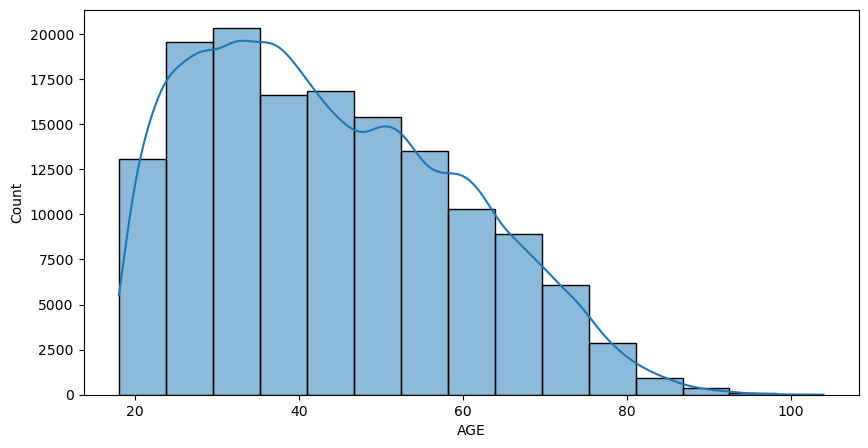

In [130]:
fig, ax = plt.subplots(1, figsize=(10,5))

sns.histplot(cus_df['AGE'], kde=True, bins=15)

plt.show();

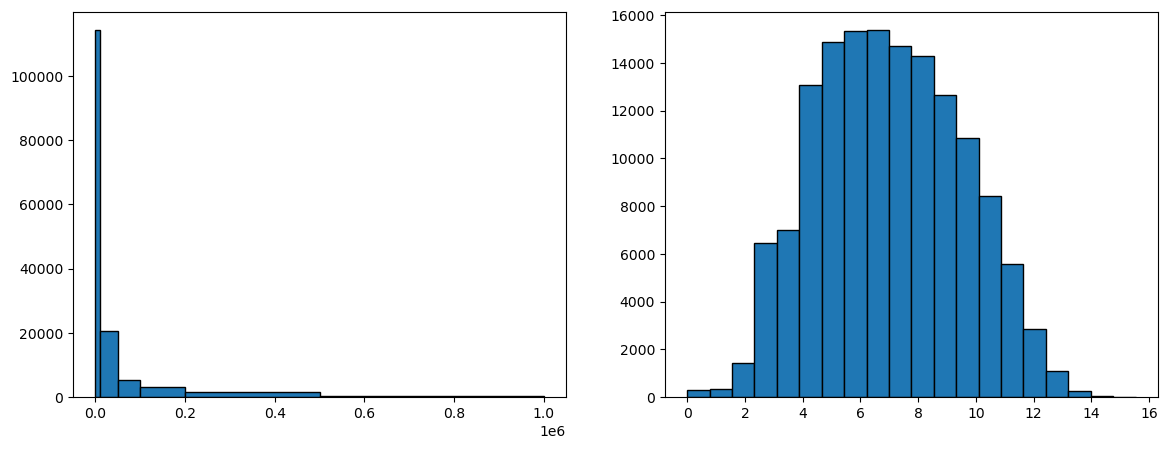

In [172]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

bins = [0, 10000, 50000, 100000, 200000, 500000, 1000000]
ax[0].hist(cus_df['TURNOVER'], bins=bins, edgecolor='black')

log_turnover = np.log(cus_df['TURNOVER']+1)
ax[1].hist(log_turnover, bins=20, edgecolor='black')

plt.show();

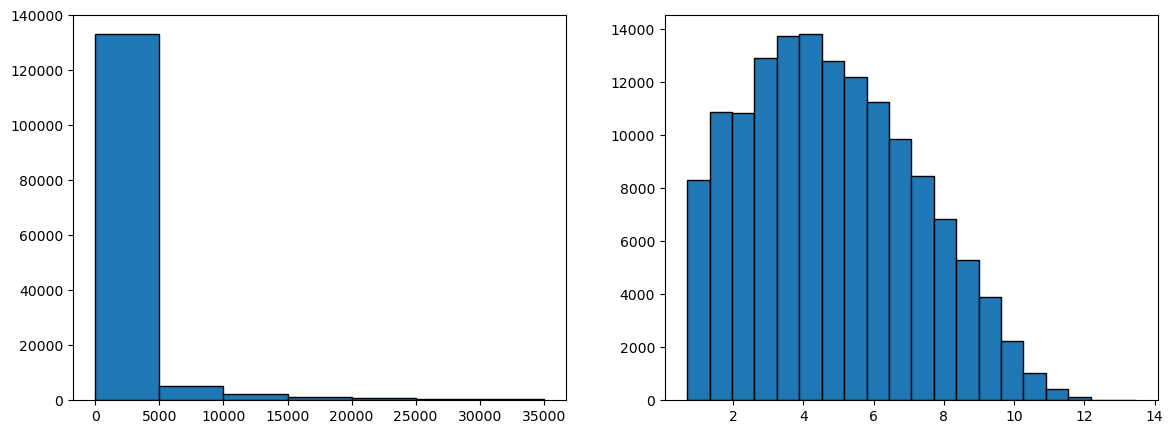

In [176]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

bins = range(0,40000, 5000)
ax[0].hist(cus_df['TICKETS'], bins=bins, edgecolor='black')

log_turnover = np.log(cus_df['TICKETS']+1)
ax[1].hist(log_turnover, bins=20, edgecolor='black')

plt.show();

In [36]:
df_agg = df.copy()
df_agg.index = pd.to_datetime(df_agg['DATE_DIM'])

In [38]:
df_turnover = df_agg.resample('d').TURNOVER.sum()
df_turnover

DATE_DIM
2021-01-01   3837745.01
2021-01-02   6169945.03
2021-01-03   2207583.19
2021-01-04   1529894.67
2021-01-05   1482174.82
                ...    
2022-12-27   2416513.24
2022-12-28   3381936.07
2022-12-29   2864956.49
2022-12-30   3002987.42
2022-12-31   5811181.70
Freq: D, Name: TURNOVER, Length: 730, dtype: float64

In [44]:
df_turnover_2021 = df_turnover[df_turnover.index.year == 2021]
df_turnover_2022 = df_turnover[df_turnover.index.year == 2022]

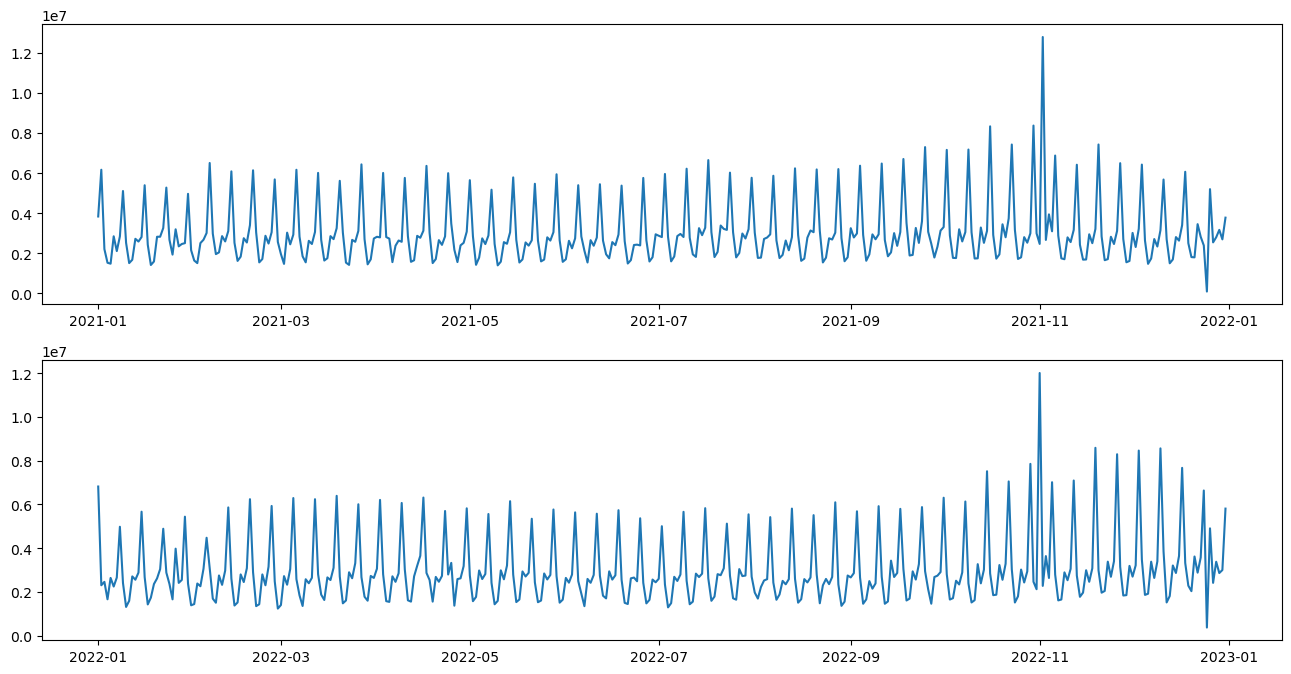

In [45]:
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_turnover_2021)
ax[1].plot(df_turnover_2022)

In [177]:
df_turnover

DATE_DIM
2021-01-01   3837745.01
2021-01-02   6169945.03
2021-01-03   2207583.19
2021-01-04   1529894.67
2021-01-05   1482174.82
                ...    
2022-12-27   2416513.24
2022-12-28   3381936.07
2022-12-29   2864956.49
2022-12-30   3002987.42
2022-12-31   5811181.70
Freq: D, Name: TURNOVER, Length: 730, dtype: float64

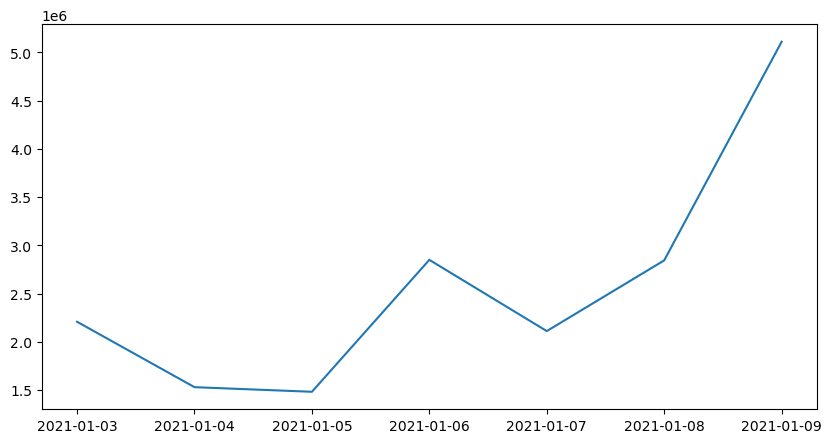

In [178]:
fig, ax = plt.subplots(1, figsize=(10,5))

ax.plot(df_sum[2:9])

In [182]:
df_turnover.index.weekday

Int64Index([4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
            ...
            3, 4, 5, 6, 0, 1, 2, 3, 4, 5],
           dtype='int64', name='DATE_DIM', length=730)

In [180]:
df_turnover_2021.argmax()

305

In [181]:
df_turnover_2021.argmin()

358

In [21]:
df_firstyear[358:359]

DATE_DIM
2022-12-25   372355.49
Freq: D, Name: TURNOVER, dtype: float64